In [ ]:
!pip install qiskit
!pip install qiskit-aer
!pip install qiskit-machine-learning
!pip install pylatexenc
!pip install qiskit-algorithms

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from imblearn.over_sampling import SMOTE
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_aer import AerSimulator
from qiskit.circuit.library import ZZFeatureMap, TwoLocal, RealAmplitudes
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.circuit.library import QNNCircuit
from qiskit_machine_learning.optimizers import COBYLA, SPSA
from tensorflow.keras.optimizers import Adam
from qiskit_algorithms.utils import algorithm_globals
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

ImportError: cannot import name 'BaseEstimator' from 'qiskit.primitives' (/usr/local/lib/python3.11/dist-packages/qiskit/primitives/__init__.py)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, QuantileTransformer
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_selection import SelectFromModel
from imblearn.over_sampling import ADASYN

In [ ]:
data = pd.read_csv('anemia.csv')

In [ ]:
print("Dataset Info:\n")
data.info()

print("\nDescriptive Statistics:\n")
print(data.describe())

In [ ]:
plt.figure(figsize=(6, 4))
sns.countplot(x='Result', data=data, palette='pastel')
plt.title('Class Distribution')
plt.show()

In [ ]:
selected_features = ['Hemoglobin', 'MCH', 'MCHC', 'MCV']
X_selected = data[selected_features]
y = data['Result']

In [ ]:
plt.figure(figsize=(10, 6))
sns.heatmap(X_selected.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Feature Correlation Heatmap (Selected Features)')
plt.show()

In [ ]:
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(X_selected)

In [ ]:
scaler = QuantileTransformer(output_distribution='normal', random_state=42)
X_scaled = scaler.fit_transform(X_selected)

In [ ]:
pca = PCA(n_components=0.99, random_state=42)
X_pca = pca.fit_transform(X_scaled)

In [ ]:
adasyn = ADASYN(random_state=42)
X_resampled, y_resampled = adasyn.fit_resample(X_pca, y)

sns.countplot(x=y_resampled, palette='pastel')
plt.title('Class Distribution After ADASYN')
plt.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)


DNN Implementation

In [ ]:
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
dnn_model = Sequential([
    Dense(128, input_dim=X_train.shape[1], activation='relu'),
    Dropout(0.4),

    Dense(128, activation='relu'),
    Dropout(0.4),

    Dense(64, activation='relu'),
    Dropout(0.3),

    Dense(32, activation='relu'),
    Dropout(0.3),

    Dense(1, activation='sigmoid')
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
dnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


# Train the model
history = dnn_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=4,
    validation_split=0.2,
    verbose=1
)

Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.5099 - loss: 0.6848 - val_accuracy: 0.7241 - val_loss: 0.6171
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7635 - loss: 0.5640 - val_accuracy: 0.8793 - val_loss: 0.3409
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8547 - loss: 0.3743 - val_accuracy: 0.7931 - val_loss: 0.4444
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8743 - loss: 0.3159 - val_accuracy: 0.8448 - val_loss: 0.2743
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8700 - loss: 0.2703 - val_accuracy: 0.8276 - val_loss: 0.3851
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9019 - loss: 0.3112 - val_accuracy: 0.8621 - val_loss: 0.2392
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8417 - loss: 0.2795 - val_accuracy: 0.8793 - val_loss: 0.2322
Epoch 8/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9057 - loss: 0.2794 - val_accuracy: 0.8621 - val

In [ ]:
y_pred_prob = dnn_model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype("int32")

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.92      0.96        37
           1       0.92      1.00      0.96        35

    accuracy                           0.96        72
   macro avg       0.96      0.96      0.96        72
weighted avg       0.96      0.96      0.96        72



VQC Implementation

In [ ]:
from qiskit.circuit.library import ZZFeatureMap, PauliFeatureMap
from qiskit.primitives import Sampler
from qiskit_algorithms.state_fidelities import ComputeUncompute
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector

def create_fm(num_features, fm_type, reps, entanglement):
    if not isinstance(num_features, int) or num_features <= 0:
        raise ValueError("num_features must be a positive integer.")
    if not isinstance(reps, int) or reps <= 0:
        raise ValueError("reps must be a positive integer.")
    if not isinstance(entanglement, (str, list)):
        raise ValueError("entanglement must be a string or a list of tuples.")

    if fm_type == 'ZZFeatureMap':
        fm = ZZFeatureMap(feature_dimension=num_features, reps=reps, entanglement=entanglement)
    elif fm_type == 'PauliFeatureMap':
        fm = PauliFeatureMap(feature_dimension=num_features, reps=reps, entanglement=entanglement, paulis=['Z', 'X', 'Y'])
    else:
        raise ValueError("Unsupported feature map type. Use 'ZZFeatureMap', 'PauliFeatureMap'.")

    return fm

def get_user_input():
    fm_type = input("Enter the feature map type (ZZFeatureMap, PauliFeatureMap): ").strip()
    reps = int(input("Enter the number of repetitions (reps): ").strip())
    entanglement = input("Enter the entanglement type (full, linear) or list of tuples (e.g., [(0,1),(1,2)]): ").strip()

    if entanglement.lower() in ['full', 'linear']:
        entanglement = entanglement.lower()
    else:
        try:
            entanglement = eval(entanglement)
            if not isinstance(entanglement, list):
                raise ValueError
        except:
            raise ValueError("Invalid format for entanglement. Use 'full', 'linear' or a list of tuples.")

    return fm_type, reps, entanglement

num_features = X_train.shape[1]

fm_type, reps, entanglement = get_user_input()

fm = create_fm(num_features, fm_type=fm_type, reps=reps, entanglement=entanglement)
print(fm)


Enter the feature map type (ZZFeatureMap, PauliFeatureMap): PauliFeatureMap
Enter the number of repetitions (reps): 3
Enter the entanglement type (full, linear) or list of tuples (e.g., [(0,1),(1,2)]): full
     ┌───────────────────────────────────────┐
q_0: ┤0                                      ├
     │                                       │
q_1: ┤1                                      ├
     │  PauliFeatureMap(x[0],x[1],x[2],x[3]) │
q_2: ┤2                                      ├
     │                                       │
q_3: ┤3                                      ├
     └───────────────────────────────────────┘


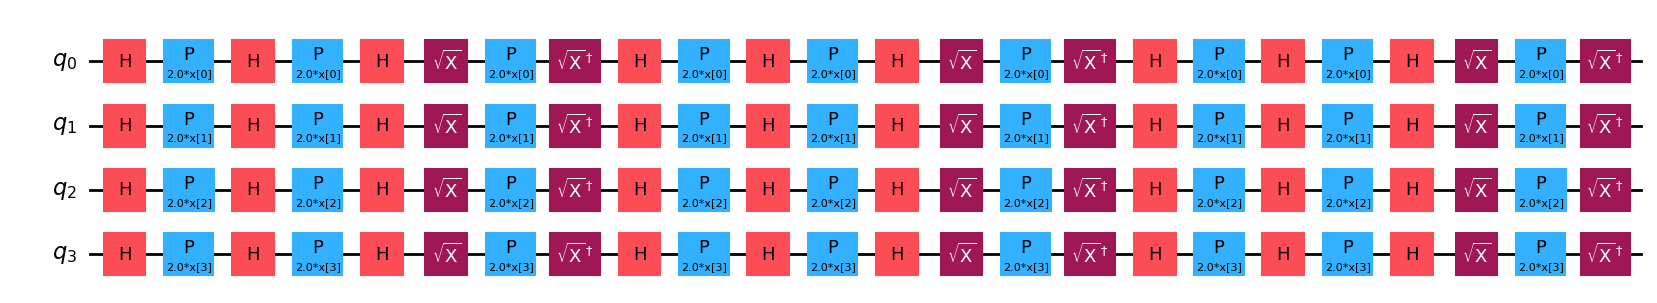

In [ ]:
fm.decompose().draw(output='mpl')

In [ ]:
from qiskit_algorithms.optimizers import COBYLA

optimizer = COBYLA(maxiter=100)

In [ ]:
from qiskit.primitives import Sampler

sampler = Sampler()

<ipython-input-21-149a83ca69cc>:3: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()


In [ ]:
from matplotlib import pyplot as plt
from IPython.display import clear_output

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

In [ ]:
from sklearn.base import ClassifierMixin  # import ClassifierMixin from sklearn.base
from qiskit.primitives import Sampler
from qiskit_machine_learning.algorithms import VQC


class VQCWrapper(ClassifierMixin):  # Now ClassifierMixin is defined, removing BaseEstimator
    def __init__(self, sampler, feature_map, ansatz, optimizer, maxiter=100):
        self.sampler = sampler
        self.feature_map = feature_map
        self.ansatz = ansatz
        self.optimizer = optimizer
        self.maxiter = maxiter  # This is used to set the maxiter in the optimizer
        self.vqc = None  # This will hold the actual VQC model after fitting

    def fit(self, X, y):
        # Instantiate and train the VQC model.
        # Removed maxiter from VQC instantiation as it is not a valid parameter
        self.vqc = VQC(sampler=self.sampler,
                       feature_map=self.feature_map,
                       ansatz=self.ansatz,
                       optimizer=self.optimizer)
        self.vqc.fit(X, y)
        self.classes_ = np.unique(y)
        return self

    def predict(self, X):
        return self.vqc.predict(X)

    def predict_proba(self, X):
        return self.vqc.predict_proba(X)

    def score(self, X, y):
        return self.vqc.score(X, y)

    def get_params(self, deep=True):
        return {"sampler": self.sampler,
                "feature_map": self.feature_map,
                "ansatz": self.ansatz,
                "optimizer": self.optimizer,
                "maxiter": self.maxiter}

    def set_params(self, **params):
        for key, value in params.items():
            setattr(self, key, value)
        return self

Stacking Model

In [ ]:
from qiskit.circuit.library import EfficientSU2
# ... (other imports)

# Before instantiating VQCWrapper, define ansatz:
num_features = X_resampled.shape[1]  # Assuming X_resampled is defined
reps = 5  # or whatever value is desired for reps
ansatz = EfficientSU2(num_qubits=num_features, reps=reps)

# Now instantiate VQCWrapper:
vqc_wrapped = VQCWrapper(sampler=sampler, feature_map=fm, ansatz=ansatz, optimizer=optimizer)

In [ ]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier, GradientBoostingClassifier

In [ ]:
base_estimators = [
    ('vqc', vqc_wrapped),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('svc', SVC(probability=True, random_state=42))
]

# The meta-learner to combine predictions from the base models.
meta_learner = LogisticRegression()

# Build the stacking ensemble
stacking_ensemble = StackingClassifier(
    estimators=base_estimators,
    final_estimator=meta_learner,
    cv=5,            # 5-fold cross-validation for base estimator predictions
    passthrough=True # Optionally pass original features to the meta-learner
)

stacking_ensemble.fit(X_train, y_train)

StackingClassifier(cv=5,
                   estimators=[('vqc',
                                <__main__.VQCWrapper object at 0x7f8cc3446f90>),
                               ('rf', RandomForestClassifier(random_state=42)),
                               ('svc', SVC(probability=True, random_state=42))],
                   final_estimator=LogisticRegression(), passthrough=True)

In [ ]:
y_pred_stack = stacking_ensemble.predict(X_test)
print("\nStacking Ensemble Accuracy:", accuracy_score(y_test, y_pred_stack))
print("Stacking Ensemble Classification Report:\n", classification_report(y_test, y_pred_stack))


Stacking Ensemble Accuracy: 0.9583333333333334
Stacking Ensemble Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.97      0.96        37
           1       0.97      0.94      0.96        35

    accuracy                           0.96        72
   macro avg       0.96      0.96      0.96        72
weighted avg       0.96      0.96      0.96        72



Bagging

In [ ]:
bagged_vqc = BaggingClassifier(estimator=vqc_wrapped, n_estimators=5, random_state=42)
bagged_rf = BaggingClassifier(estimator=RandomForestClassifier(n_estimators=100, random_state=42),
                              n_estimators=5, random_state=42)

bagging_ensemble = VotingClassifier(
    estimators=[('bagged_vqc', bagged_vqc),
                ('bagged_rf', bagged_rf)],
    voting='soft'
)
bagging_ensemble.fit(X_train, y_train)

VotingClassifier(estimators=[('bagged_vqc',
                              BaggingClassifier(estimator=<__main__.VQCWrapper object at 0x7f8cc3446f90>,
                                                n_estimators=5,
                                                random_state=42)),
                             ('bagged_rf',
                              BaggingClassifier(estimator=RandomForestClassifier(random_state=42),
                                                n_estimators=5,
                                                random_state=42))],
                 voting='soft')

In [ ]:
y_pred_bagging = bagging_ensemble.predict(X_test)
print("\nBagging Ensemble Accuracy:", accuracy_score(y_test, y_pred_bagging))
print("Bagging Ensemble Classification Report:\n", classification_report(y_test, y_pred_bagging))


Bagging Ensemble Accuracy: 0.875
Bagging Ensemble Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.97      0.89        37
           1       0.96      0.77      0.86        35

    accuracy                           0.88        72
   macro avg       0.89      0.87      0.87        72
weighted avg       0.89      0.88      0.87        72



Boosting

In [ ]:
boosting_ensemble = VotingClassifier(
    estimators=[('vqc', vqc_wrapped),
                ('gbc', GradientBoostingClassifier(n_estimators=100, random_state=42))],
    voting='soft'
)
boosting_ensemble.fit(X_train, y_train)

VotingClassifier(estimators=[('vqc',
                              <__main__.VQCWrapper object at 0x7f8cc3446f90>),
                             ('gbc',
                              GradientBoostingClassifier(random_state=42))],
                 voting='soft')

In [ ]:
y_pred_boosting = boosting_ensemble.predict(X_test)
print("\nBoosting Ensemble Accuracy:", accuracy_score(y_test, y_pred_boosting))
print("Boosting Ensemble Classification Report:\n", classification_report(y_test, y_pred_boosting))


Boosting Ensemble Accuracy: 0.9166666666666666
Boosting Ensemble Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.92      0.92        37
           1       0.91      0.91      0.91        35

    accuracy                           0.92        72
   macro avg       0.92      0.92      0.92        72
weighted avg       0.92      0.92      0.92        72



VQC

In [ ]:
from qiskit.circuit.library import EfficientSU2
from qiskit_machine_learning.algorithms import VQC
import time

maxiter=200
reps=5
ansatz = EfficientSU2(num_qubits=num_features, reps=reps)
optimizer = COBYLA(maxiter=maxiter)
vqc = VQC(sampler=sampler, feature_map=fm, ansatz=ansatz, optimizer=optimizer)
start = time.time()
vqc.fit(X_train, y_train.to_numpy())

In [ ]:
y_pred = vqc.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

report = classification_report(y_test, y_pred)

In [ ]:
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:\n", report)

Accuracy: 0.5972

Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.78      0.67        37
           1       0.64      0.40      0.49        35

    accuracy                           0.60        72
   macro avg       0.61      0.59      0.58        72
weighted avg       0.61      0.60      0.58        72



DBN

In [ ]:
from sklearn.neural_network import BernoulliRBM
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

rbm = BernoulliRBM(random_state=42, n_iter=20, n_components=256)
logistic = LogisticRegression(max_iter=1000, random_state=42)
classifier = Pipeline(steps=[('rbm', rbm), ('logistic', logistic)])

# Train the model
classifier.fit(X_train, y_train)

Pipeline(steps=[('rbm', BernoulliRBM(n_iter=20, random_state=42)),
                ('logistic',
                 LogisticRegression(max_iter=1000, random_state=42))])

In [ ]:
y_pred = classifier.predict(X_test)
y_prob = classifier.predict_proba(X_test)[:, 1]

# Evaluate the model
roc_score = roc_auc_score(y_test, y_prob)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_score)

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.84      0.87        37
           1       0.84      0.91      0.88        35

    accuracy                           0.88        72
   macro avg       0.88      0.88      0.87        72
weighted avg       0.88      0.88      0.87        72

ROC AUC Score: 0.9173745173745174


Graphs

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
      Model  Accuracy   ROC AUC  F1 Score
0   Bagging  0.875000  0.988417  0.857143
1  Stacking  0.958333  0.989189  0.956522
2  Boosting  0.916667  0.972201  0.914286
3       DNN  0.958333  0.990734  0.958904
4       VQC  0.597222  0.690347  0.491228


<ipython-input-41-182c0a5a5efb>:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Accuracy', data=metrics_df, palette='viridis')
<ipython-input-41-182c0a5a5efb>:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='ROC AUC', data=metrics_df, palette='viridis')
<ipython-input-41-182c0a5a5efb>:71: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='F1 Score', data=metrics_df, palette='viridis')


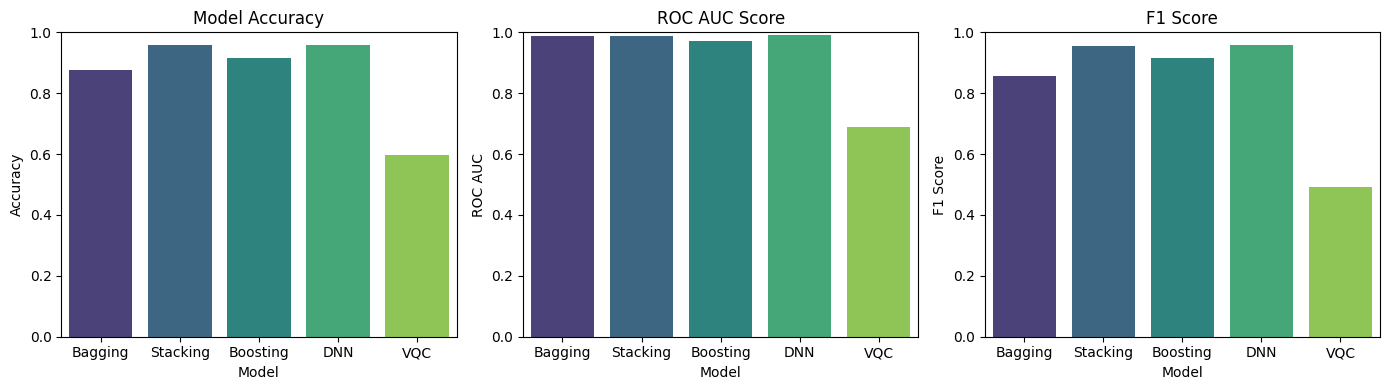

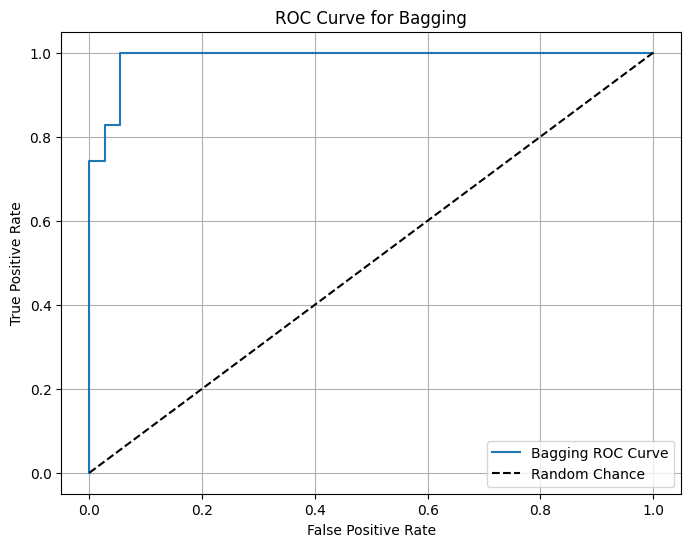

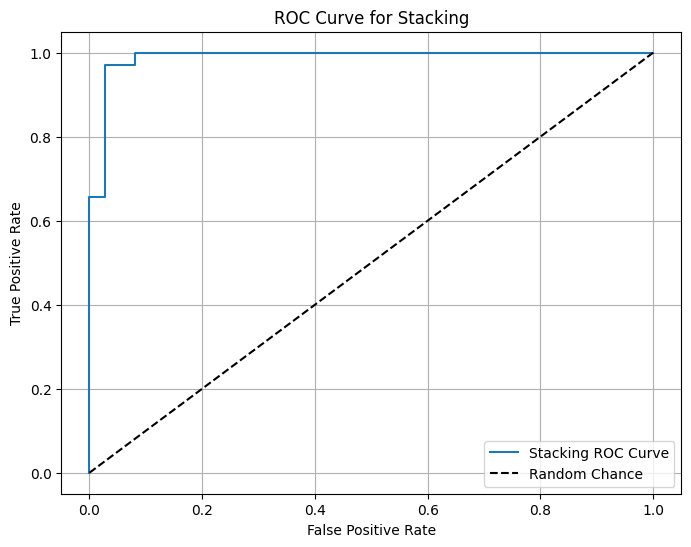

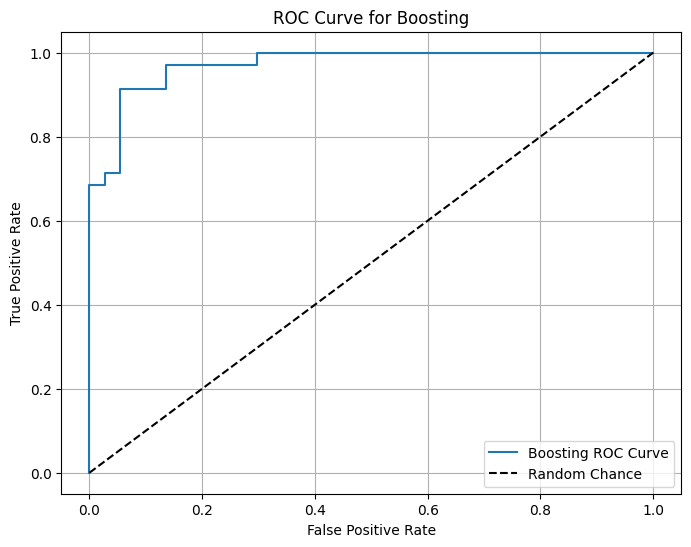

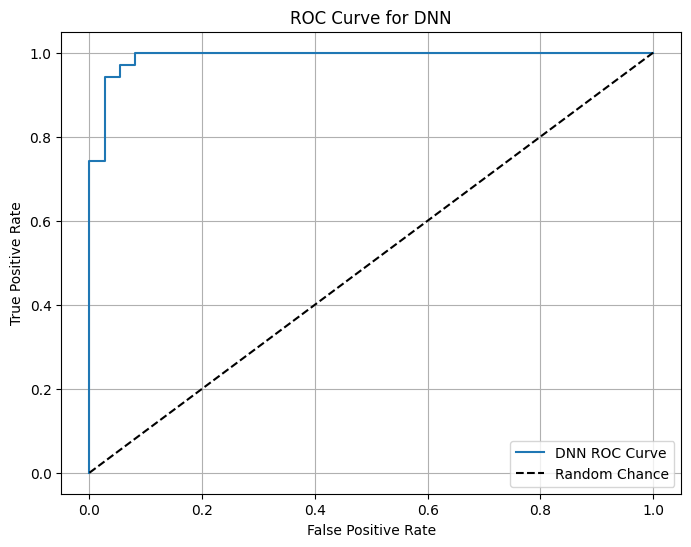

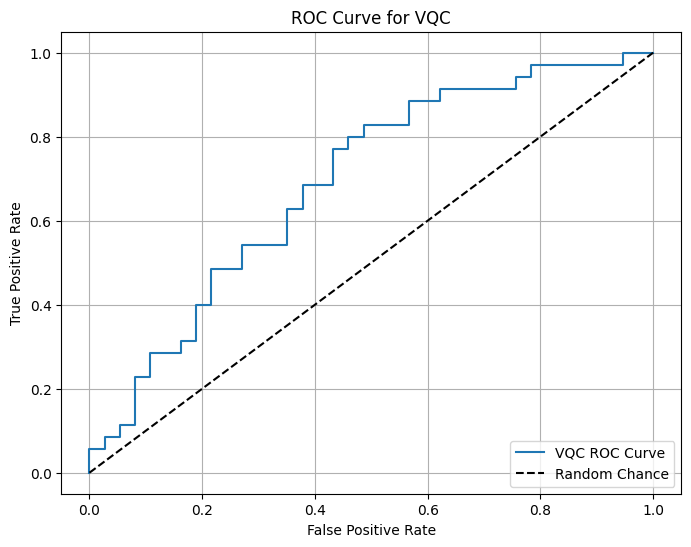

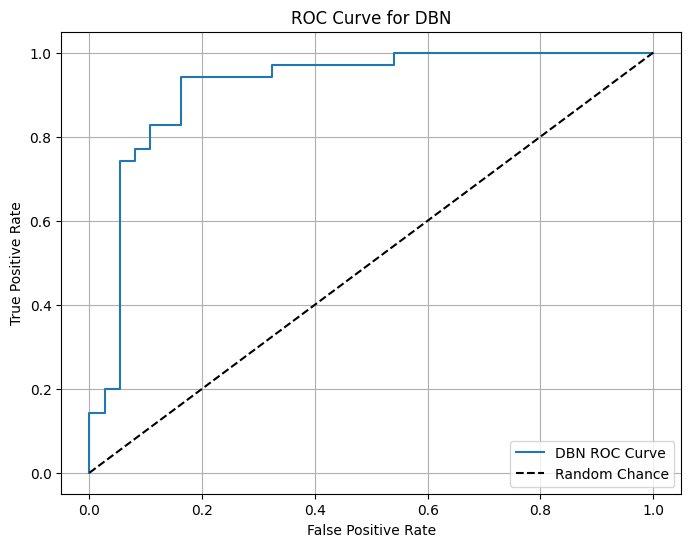

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, roc_curve

# ----------------------------
# Compute Performance Metrics for Each Model
# ----------------------------

# For Bagging Ensemble
y_pred_bagging = bagging_ensemble.predict(X_test)
y_prob_bagging = bagging_ensemble.predict_proba(X_test)[:, 1]
acc_bagging = accuracy_score(y_test, y_pred_bagging)
roc_bagging = roc_auc_score(y_test, y_prob_bagging)
f1_bagging = f1_score(y_test, y_pred_bagging)

# For Stacking Ensemble
y_pred_stacking = stacking_ensemble.predict(X_test)
y_prob_stacking = stacking_ensemble.predict_proba(X_test)[:, 1]
acc_stacking = accuracy_score(y_test, y_pred_stacking)
roc_stacking = roc_auc_score(y_test, y_prob_stacking)
f1_stacking = f1_score(y_test, y_pred_stacking)

# For Boosting Ensemble
y_pred_boosting = boosting_ensemble.predict(X_test)
y_prob_boosting = boosting_ensemble.predict_proba(X_test)[:, 1]
acc_boosting = accuracy_score(y_test, y_pred_boosting)
roc_boosting = roc_auc_score(y_test, y_prob_boosting)
f1_boosting = f1_score(y_test, y_pred_boosting)

# For DNN Model
y_prob_dnn = dnn_model.predict(X_test).ravel()
y_pred_dnn = (y_prob_dnn > 0.5).astype("int32")
acc_dnn = accuracy_score(y_test, y_pred_dnn)
roc_dnn = roc_auc_score(y_test, y_prob_dnn)
f1_dnn = f1_score(y_test, y_pred_dnn)

# For Standalone VQC Model
y_pred_vqc = vqc.predict(X_test)
y_prob_vqc = vqc.predict_proba(X_test)[:, 1]
acc_vqc = accuracy_score(y_test, y_pred_vqc)
roc_vqc = roc_auc_score(y_test, y_prob_vqc)
f1_vqc = f1_score(y_test, y_pred_vqc)

# Collect all metrics into a DataFrame for visualization.
metrics_df = pd.DataFrame({
    'Model': ['Bagging', 'Stacking', 'Boosting', 'DNN', 'VQC'],
    'Accuracy': [acc_bagging, acc_stacking, acc_boosting, acc_dnn, acc_vqc],
    'ROC AUC': [roc_bagging, roc_stacking, roc_boosting, roc_dnn, roc_vqc],
    'F1 Score': [f1_bagging, f1_stacking, f1_boosting, f1_dnn, f1_vqc]
})
print(metrics_df)

# ----------------------------
# Plot Bar Charts of the Performance Metrics
# ----------------------------
plt.figure(figsize=(14, 4))

plt.subplot(1, 3, 1)
sns.barplot(x='Model', y='Accuracy', data=metrics_df, palette='viridis')
plt.title('Model Accuracy')
plt.ylim(0, 1)

plt.subplot(1, 3, 2)
sns.barplot(x='Model', y='ROC AUC', data=metrics_df, palette='viridis')
plt.title('ROC AUC Score')
plt.ylim(0, 1)

plt.subplot(1, 3, 3)
sns.barplot(x='Model', y='F1 Score', data=metrics_df, palette='viridis')
plt.title('F1 Score')
plt.ylim(0, 1)

plt.tight_layout()
plt.show()

# ----------------------------
# Plot ROC Curves for All Models in a Single Figure
# ----------------------------
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

# Create a dictionary to hold model labels and their predicted probabilities
roc_models = {
    'Bagging': y_prob_bagging,
    'Stacking': y_prob_stacking,
    'Boosting': y_prob_boosting,
    'DNN': y_prob_dnn,
    'VQC': y_prob_vqc,
    'DBN': y_prob_dbn
}

# Loop over each model and plot a separate ROC curve
for model_name, y_prob in roc_models.items():
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'{model_name} ROC Curve')
    plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {model_name}')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Performance Metrics Comparison:
      Model  Accuracy   ROC AUC  F1 Score
0   Bagging  0.875000  0.988417  0.857143
1  Stacking  0.958333  0.989189  0.956522
2  Boosting  0.916667  0.972201  0.914286
3       DNN  0.958333  0.990734  0.958904
4       VQC  0.597222  0.690347  0.491228
5       DBN  0.875000  0.917375  0.876712


<ipython-input-39-6837b6965481>:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Accuracy', data=metrics_df, palette='coolwarm')
<ipython-input-39-6837b6965481>:78: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='ROC AUC', data=metrics_df, palette='coolwarm')
<ipython-input-39-6837b6965481>:84: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='F1 Score', data=metrics_df, palette='coolwarm')


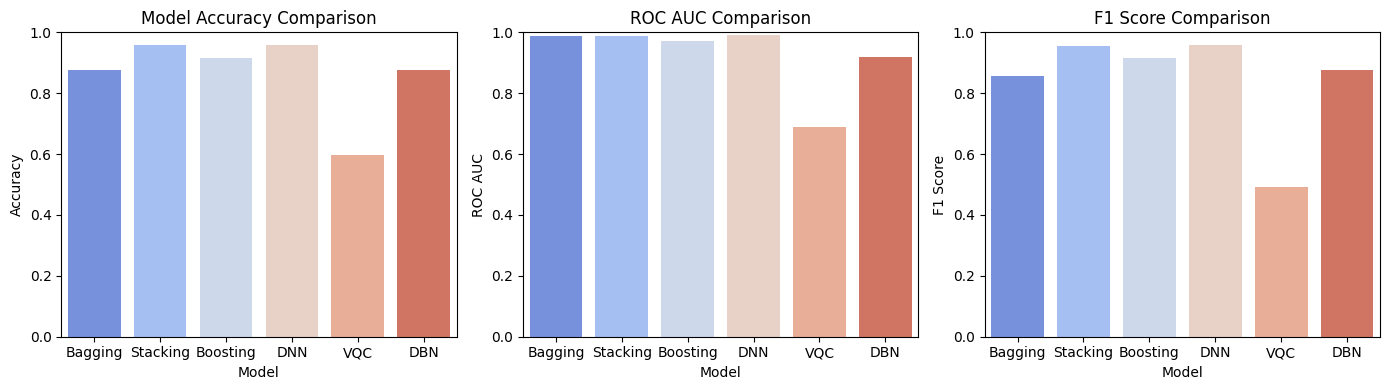

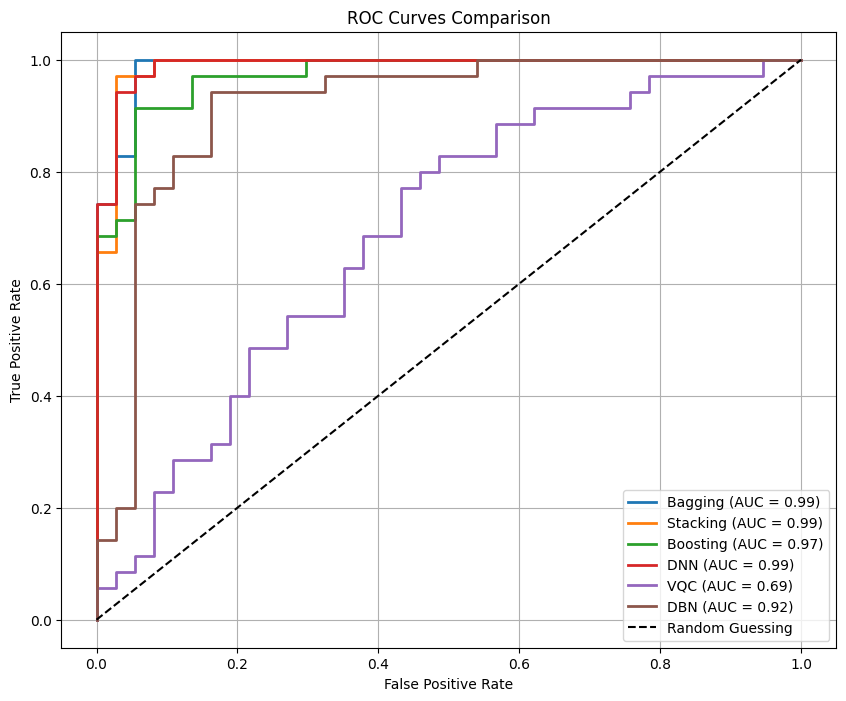

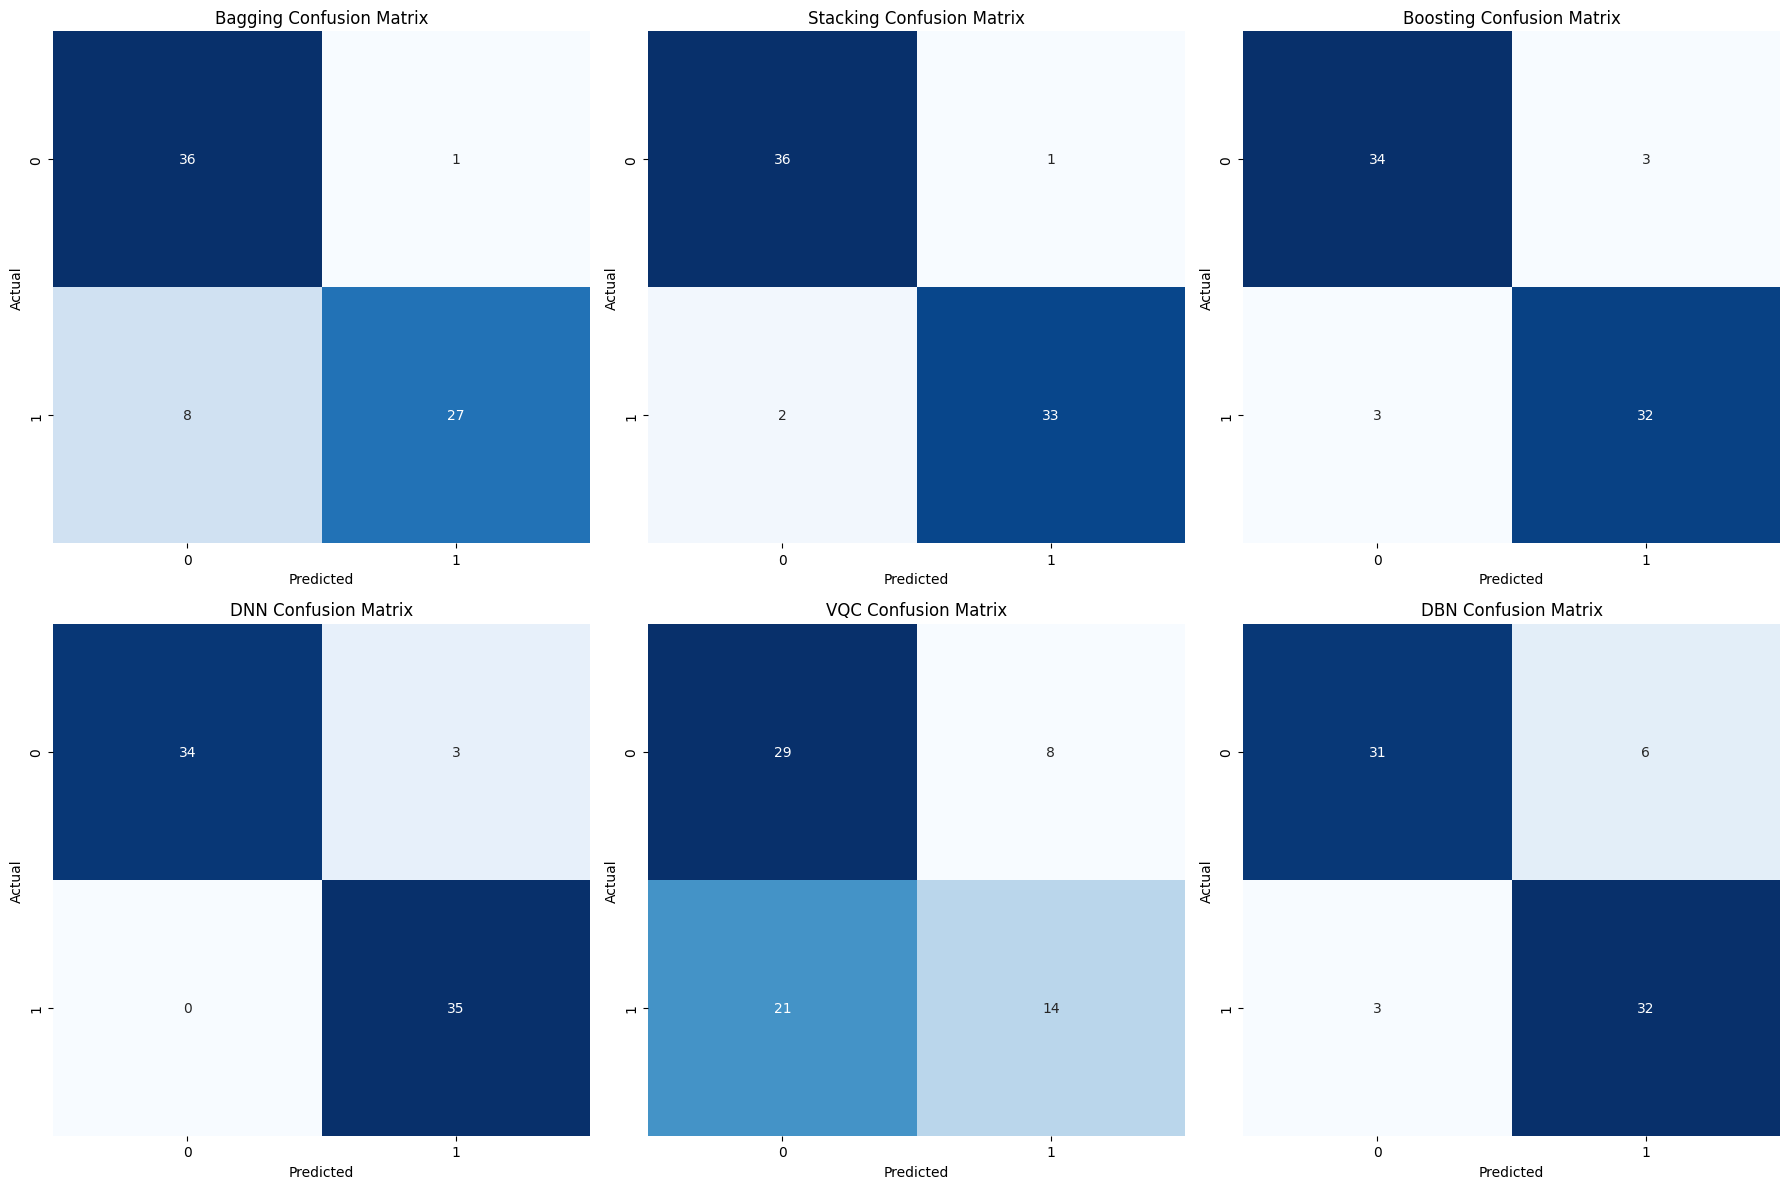

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, roc_curve, confusion_matrix

# ----------------------------
# Compute Performance Metrics for All Models
# ----------------------------

# Bagging Ensemble
y_pred_bagging = bagging_ensemble.predict(X_test)
y_prob_bagging = bagging_ensemble.predict_proba(X_test)[:, 1]
acc_bagging = accuracy_score(y_test, y_pred_bagging)
roc_bagging = roc_auc_score(y_test, y_prob_bagging)
f1_bagging = f1_score(y_test, y_pred_bagging)

# Stacking Ensemble
y_pred_stacking = stacking_ensemble.predict(X_test)
y_prob_stacking = stacking_ensemble.predict_proba(X_test)[:, 1]
acc_stacking = accuracy_score(y_test, y_pred_stacking)
roc_stacking = roc_auc_score(y_test, y_prob_stacking)
f1_stacking = f1_score(y_test, y_pred_stacking)

# Boosting Ensemble
y_pred_boosting = boosting_ensemble.predict(X_test)
y_prob_boosting = boosting_ensemble.predict_proba(X_test)[:, 1]
acc_boosting = accuracy_score(y_test, y_pred_boosting)
roc_boosting = roc_auc_score(y_test, y_prob_boosting)
f1_boosting = f1_score(y_test, y_pred_boosting)

# DNN Model
y_prob_dnn = dnn_model.predict(X_test).ravel()
y_pred_dnn = (y_prob_dnn > 0.5).astype("int32")
acc_dnn = accuracy_score(y_test, y_pred_dnn)
roc_dnn = roc_auc_score(y_test, y_prob_dnn)
f1_dnn = f1_score(y_test, y_pred_dnn)

# VQC Model
y_pred_vqc = vqc.predict(X_test)
y_prob_vqc = vqc.predict_proba(X_test)[:, 1]
acc_vqc = accuracy_score(y_test, y_pred_vqc)
roc_vqc = roc_auc_score(y_test, y_prob_vqc)
f1_vqc = f1_score(y_test, y_pred_vqc)

# DBN Model
y_pred_dbn = classifier.predict(X_test)
y_prob_dbn = classifier.predict_proba(X_test)[:, 1]
acc_dbn = accuracy_score(y_test, y_pred_dbn)
roc_dbn = roc_auc_score(y_test, y_prob_dbn)
f1_dbn = f1_score(y_test, y_pred_dbn)

# ----------------------------
# Create Consolidated Metrics DataFrame
# ----------------------------
metrics_df = pd.DataFrame({
    'Model': ['Bagging', 'Stacking', 'Boosting', 'DNN', 'VQC', 'DBN'],
    'Accuracy': [acc_bagging, acc_stacking, acc_boosting, acc_dnn, acc_vqc, acc_dbn],
    'ROC AUC': [roc_bagging, roc_stacking, roc_boosting, roc_dnn, roc_vqc, roc_dbn],
    'F1 Score': [f1_bagging, f1_stacking, f1_boosting, f1_dnn, f1_vqc, f1_dbn]
})
print("Performance Metrics Comparison:")
print(metrics_df)

# ----------------------------
# Visualization: Bar Charts
# ----------------------------
plt.figure(figsize=(14, 4))

# Accuracy
plt.subplot(1, 3, 1)
sns.barplot(x='Model', y='Accuracy', data=metrics_df, palette='coolwarm')
plt.title('Model Accuracy Comparison')
plt.ylim(0, 1.0)

# ROC AUC
plt.subplot(1, 3, 2)
sns.barplot(x='Model', y='ROC AUC', data=metrics_df, palette='coolwarm')
plt.title('ROC AUC Comparison')
plt.ylim(0, 1.0)

# F1 Score
plt.subplot(1, 3, 3)
sns.barplot(x='Model', y='F1 Score', data=metrics_df, palette='coolwarm')
plt.title('F1 Score Comparison')
plt.ylim(0, 1.0)

plt.tight_layout()
plt.show()

# ----------------------------
# Visualization: ROC Curves
# ----------------------------
roc_models = {
    'Bagging': y_prob_bagging,
    'Stacking': y_prob_stacking,
    'Boosting': y_prob_boosting,
    'DNN': y_prob_dnn,
    'VQC': y_prob_vqc,
    'DBN': y_prob_dbn
}

plt.figure(figsize=(10, 8))
for model_name, y_prob in roc_models.items():
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc_score(y_test, y_prob):.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# ----------------------------
# Visualization: Confusion Matrices
# ----------------------------
models = {
    'Bagging': y_pred_bagging,
    'Stacking': y_pred_stacking,
    'Boosting': y_pred_boosting,
    'DNN': y_pred_dnn,
    'VQC': y_pred_vqc,
    'DBN': y_pred_dbn
}

plt.figure(figsize=(18, 12))
for i, (name, preds) in enumerate(models.items(), 1):
    plt.subplot(2, 3, i)
    sns.heatmap(confusion_matrix(y_test, preds),
                annot=True, fmt='d',
                cmap='Blues',
                cbar=False)
    plt.title(f'{name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
plt.tight_layout()
plt.show()

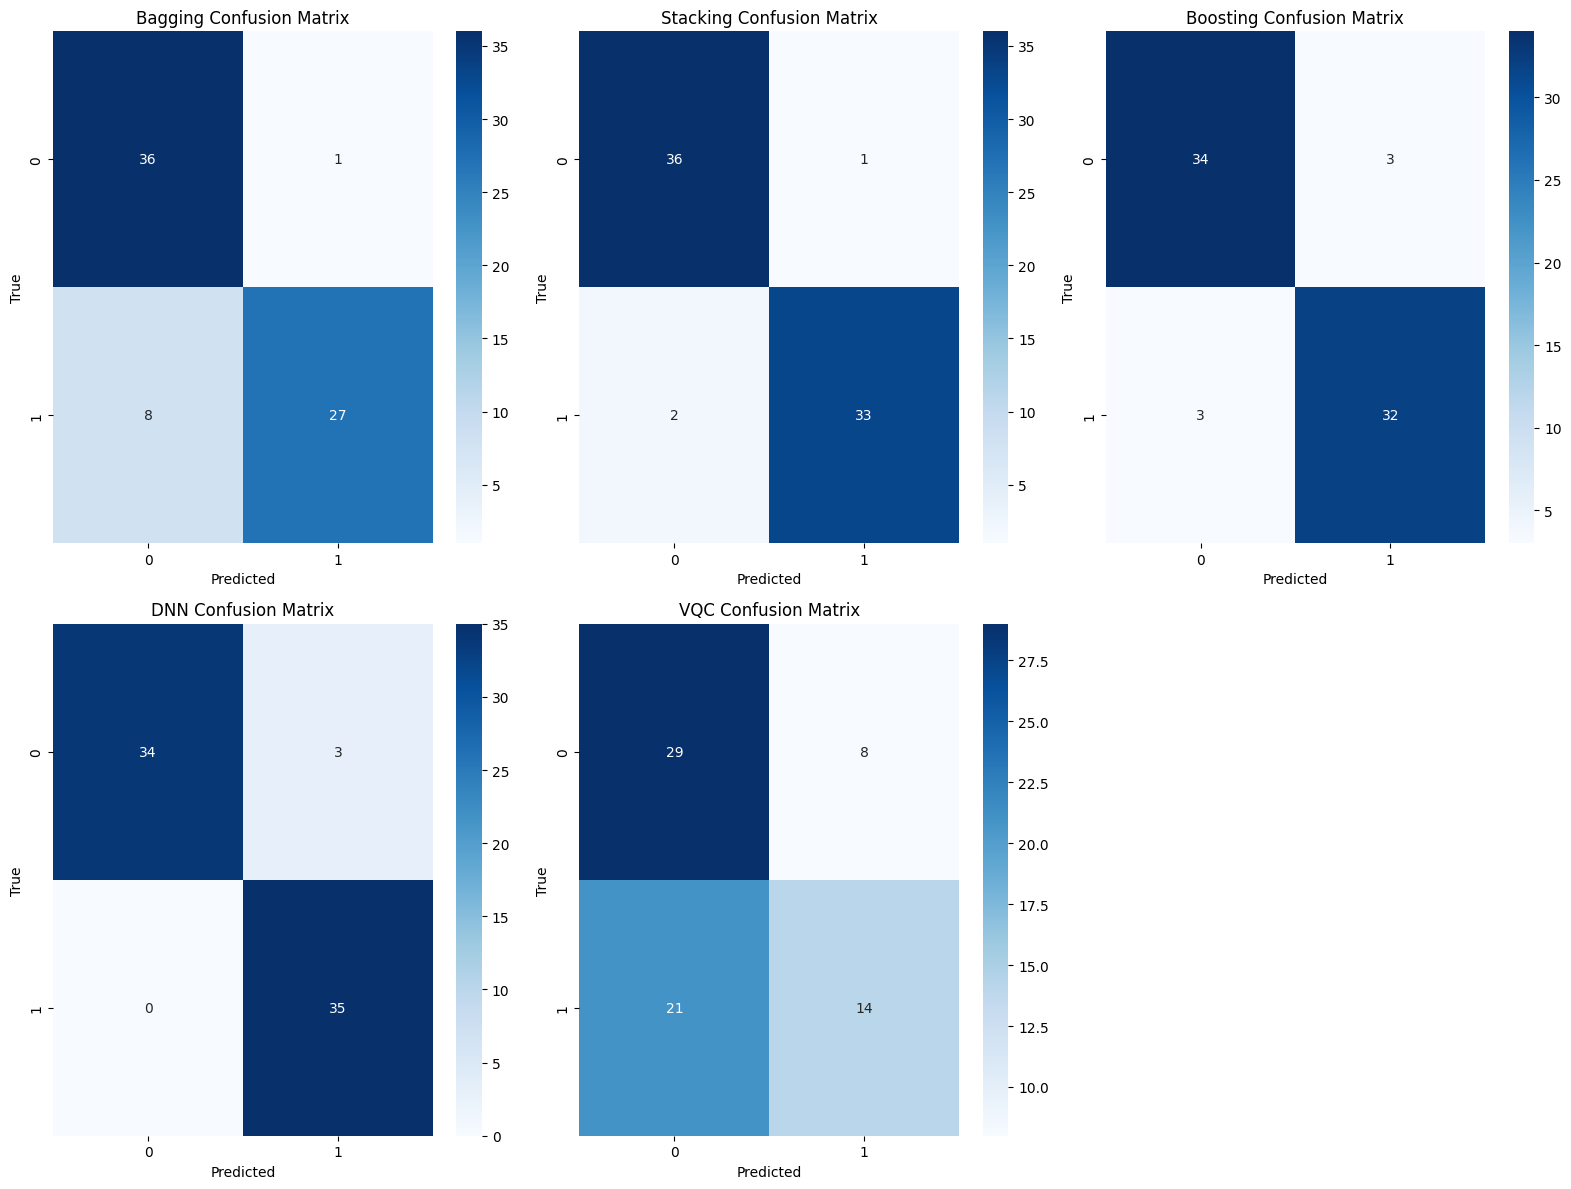

In [ ]:
# Plot Confusion Matrices for Each Model
# ----------------------------
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, roc_curve, confusion_matrix
models = {
    'Bagging': (y_test, y_pred_bagging),
    'Stacking': (y_test, y_pred_stacking),
    'Boosting': (y_test, y_pred_boosting),
    'DNN': (y_test, y_pred_dnn),
    'VQC': (y_test, y_pred_vqc)
}

plt.figure(figsize=(16, 12))
for i, (model_name, (y_true, y_pred)) in enumerate(models.items()):
    cm = confusion_matrix(y_true, y_pred)
    plt.subplot(2, 3, i+1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
plt.tight_layout()
plt.show()